In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from pycaret.classification import setup, compare_models, pull
import mlflow
import mlflow.sklearn

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space'
]

newsgroups_train = fetch_20newsgroups(
    subset='train',
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=('headers', 'footers', 'quotes')
)

newsgroups_test = fetch_20newsgroups(
    subset='test',
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=('headers', 'footers', 'quotes')
)

df_train = pd.DataFrame({
    'text': newsgroups_train.data,
    'target': newsgroups_train.target
})

df_test = pd.DataFrame({
    'text': newsgroups_test.data,
    'target': newsgroups_test.target
})

df_train['category'] = df_train['target'].map(
    {i: name for i, name in enumerate(newsgroups_train.target_names)}
)

df_test['category'] = df_test['target'].map(
    {i: name for i, name in enumerate(newsgroups_test.target_names)}
)

In [25]:
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")
df_train.head(10)

Train: (2034, 3)
Test: (1353, 3)


,text,target,category
0,"Hi,\n\nI've noticed that if you only save a mo...",1,comp.graphics
1,"\n\nSeems to be, barring evidence to the contr...",3,talk.religion.misc
2,\n >In article <1993Apr19.020359.26996@sq.sq.c...,2,sci.space
3,I have a request for those who would like to s...,0,alt.atheism
4,AW&ST had a brief blurb on a Manned Lunar Exp...,2,sci.space
5,\nThere are definitely quite a few horrible de...,0,alt.atheism
6,Mark Prado\n \n \nOld pioneer song from the ...,2,sci.space
7,\nAcorn Replay running on a 25MHz ARM 3 proces...,1,comp.graphics
8,\nTheir Hiten engineering-test mission spent a...,2,sci.space
9,I'm interested in find out what is involved in...,1,comp.graphics


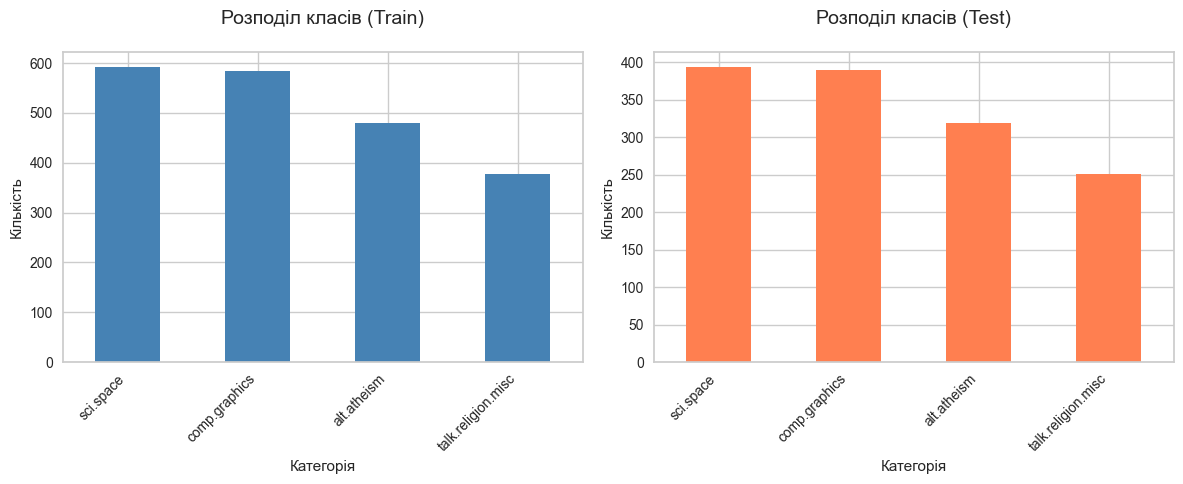

In [26]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df_train['category'].value_counts().plot(kind='bar', color='steelblue')
plt.title('Розподіл класів (Train)', fontsize=14, pad=20)
plt.xlabel('Категорія')
plt.ylabel('Кількість')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.subplot(1, 2, 2)
df_test['category'].value_counts().plot(kind='bar', color='coral')
plt.title('Розподіл класів (Test)', fontsize=14, pad=20)
plt.xlabel('Категорія')
plt.ylabel('Кількість')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [68]:
example = df_train[df_train['category'] == 'sci.space'].iloc[0]['text']
print(example[:1000])


 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.com (Mark Brader) 

MB>                                                             So the
MB> 1970 figure seems unlikely to actually be anything but a perijove.

JG>Sorry, _perijoves_...I'm not used to talking this language.

Couldn't we just say periapsis or apoapsis?

 


In [28]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # топ-5000 найважливіших слів
    min_df=2,           # Слово має з'явитися мінімум у 2 доках
    max_df=0.8,         # ігнорурування слів що зявляються у > 80% документів
    ngram_range=(1, 2),
    stop_words='english' # Видалення стоп-слів
)

X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['text'])
y_train = df_train['target']

X_test_tfidf = tfidf_vectorizer.transform(df_test['text'])
y_test = df_test['target']

print(f"Train: {X_train_tfidf.shape}")
print(f"Test: {X_test_tfidf.shape}")

Train: (2034, 5000)
Test: (1353, 5000)


In [29]:
df_train_tfidf = pd.DataFrame(
    X_train_tfidf.toarray(),
    columns=[f'feature_{i}' for i in range(X_train_tfidf.shape[1])]
)
df_train_tfidf['target'] = y_train.values

df_test_tfidf = pd.DataFrame(
    X_test_tfidf.toarray(),
    columns=[f'feature_{i}' for i in range(X_test_tfidf.shape[1])]
)
df_test_tfidf['target'] = y_test.values

df_train_tfidf.shape

(2034, 5001)

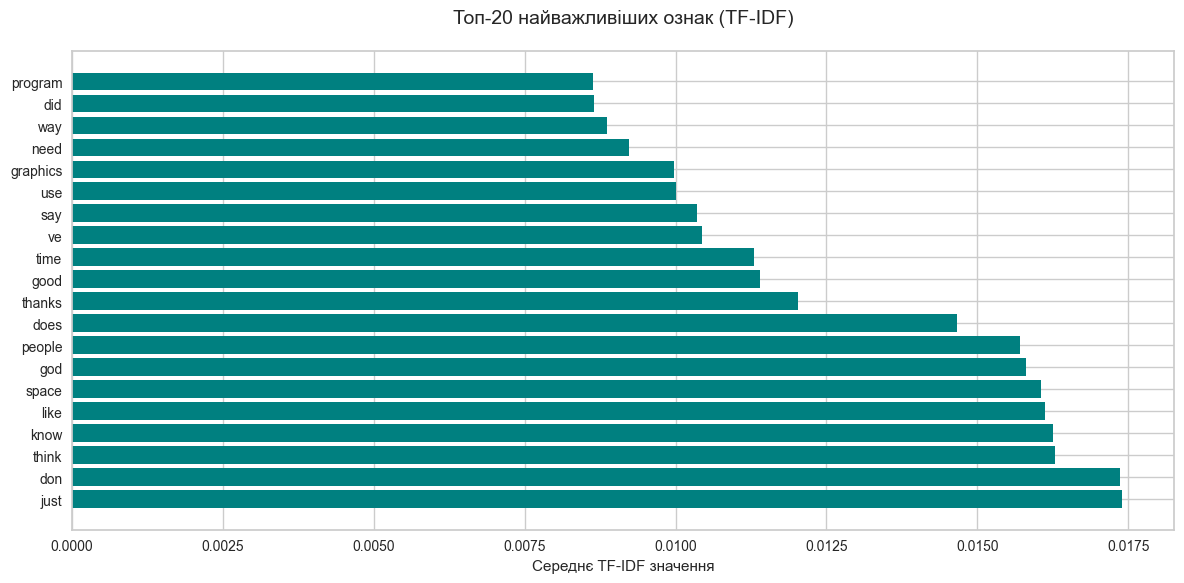

In [30]:
feature_names = tfidf_vectorizer.get_feature_names_out()
avg_tfidf = np.asarray(X_train_tfidf.mean(axis=0)).flatten()
top_n = 20
top_indices = avg_tfidf.argsort()[-top_n:][::-1]

plt.figure(figsize=(12, 6))
plt.barh(range(top_n), avg_tfidf[top_indices], color='teal')
plt.yticks(range(top_n), [feature_names[i] for i in top_indices])
plt.xlabel('Середнє TF-IDF значення')
plt.title(f'Топ-{top_n} найважливіших ознак (TF-IDF)', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('top_tfidf_features.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
clf_setup = setup(
    data=df_train_tfidf,
    target='target',
    session_id=42,
    verbose=False,
    normalize=True
    fold=5,                 # 5-fold cross validation
    log_experiment=False,    # Логування в mlflow
    experiment_name='newsgroups_classification',
    use_gpu=False
)

In [32]:
best_models = compare_models(
    n_select=3,
    sort='Accuracy',
    verbose=False
)

results = pull()

In [33]:
print(results[['Model', 'Accuracy', 'AUC', 'Recall', 'Prec.', 'F1']])

                                    Model  Accuracy     AUC  Recall   Prec.  \
et                 Extra Trees Classifier    0.7638  0.9335  0.7638  0.7624   
lr                    Logistic Regression    0.7632  0.0000  0.7632  0.7674   
rf               Random Forest Classifier    0.7435  0.9232  0.7435  0.7408   
svm                   SVM - Linear Kernel    0.7400  0.0000  0.7400  0.7378   
ridge                    Ridge Classifier    0.7189  0.0000  0.7189  0.7200   
gbc          Gradient Boosting Classifier    0.7189  0.0000  0.7189  0.7212   
lda          Linear Discriminant Analysis    0.7168  0.0000  0.7168  0.7202   
lightgbm  Light Gradient Boosting Machine    0.6718  0.8900  0.6718  0.6719   
nb                            Naive Bayes    0.6423  0.7657  0.6423  0.6452   
ada                  Ada Boost Classifier    0.6071  0.0000  0.6071  0.6488   
dt               Decision Tree Classifier    0.5938  0.7562  0.5938  0.5890   
knn                K Neighbors Classifier    0.3500 

In [66]:
with mlflow.start_run(run_name="newsgroups_classification"):
    
    # Лог параметрів
    mlflow.log_param("n_top_models", 3)
    mlflow.log_param("folds", 5)
    mlflow.log_param("normalize", True)
    
    # Лог метрик
    top_model_metrics = results.iloc[0]
    mlflow.log_metric("Accuracy", top_model_metrics["Accuracy"])
    mlflow.log_metric("AUC", top_model_metrics["AUC"])
    mlflow.log_metric("Recall", top_model_metrics["Recall"])
    mlflow.log_metric("Prec.", top_model_metrics["Prec."])
    mlflow.log_metric("F1", top_model_metrics["F1"])
    
    # Лог моделі 
    mlflow.sklearn.log_model(best_models[0], name="model")

2025/10/31 02:34:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [67]:
mlflow.set_experiment("newsgroups_classification")
print("Tracking URI:", mlflow.get_tracking_uri())
print("Experiment ID:", mlflow.get_experiment_by_name("newsgroups_classification"))

Tracking URI: file:///d:/Users/Sofia/MagistracyAM/FirstYear/Semester1/DeepLearningModels/CODE/HW1-PyCaret-Text-Classification/mlruns
Experiment ID: <Experiment: artifact_location='file:///d:/Users/Sofia/MagistracyAM/FirstYear/Semester1/DeepLearningModels/CODE/HW1-PyCaret-Text-Classification/mlruns/572052571486068492', creation_time=1761853984091, experiment_id='572052571486068492', last_update_time=1761853984091, lifecycle_stage='active', name='newsgroups_classification', tags={}>


In [35]:
best_model = best_models[0]
best_model

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

In [36]:
tuned_model = tune_model(
    best_model,
    optimize='Accuracy',
    n_iter=10,
    verbose=False
)

In [37]:
final_model = finalize_model(tuned_model)

y_pred = predict_model(final_model, data=df_test_tfidf)

accuracy = accuracy_score(df_test_tfidf['target'], y_pred['prediction_label'])

print(f"Accuracy (test): {accuracy:.4f}")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7258,0.9173,0.7258,0.7214,0.7226,0.6297,0.6302


Accuracy (test): 0.7258


In [38]:
report = classification_report(
    df_test_tfidf['target'],
    y_pred['prediction_label'],
    target_names=newsgroups_train.target_names
)
print(report)

                    precision    recall  f1-score   support

       alt.atheism       0.61      0.65      0.63       319
     comp.graphics       0.83      0.88      0.86       389
         sci.space       0.80      0.79      0.80       394
talk.religion.misc       0.57      0.48      0.52       251

          accuracy                           0.73      1353
         macro avg       0.70      0.70      0.70      1353
      weighted avg       0.72      0.73      0.72      1353



In [39]:
cm = confusion_matrix(df_test_tfidf['target'], y_pred['prediction_label'])
print(cm)

[[206  18  34  61]
 [ 15 344  22   8]
 [ 27  33 311  23]
 [ 90  19  21 121]]


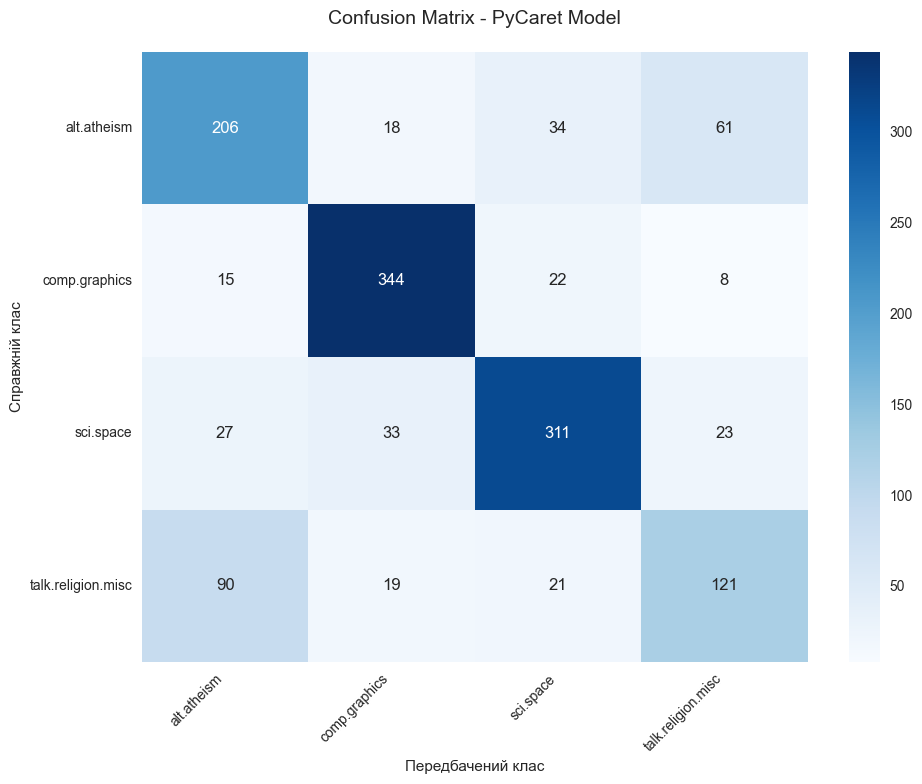

In [40]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=newsgroups_train.target_names,
    yticklabels=newsgroups_train.target_names
)
plt.title('Confusion Matrix - PyCaret Model', fontsize=14, pad=20)
plt.ylabel('Справжній клас')
plt.xlabel('Передбачений клас')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_pycaret.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
plot_model(final_model, plot='auc', save=True)

plot_model(final_model, plot='feature', save=True)

'Feature Importance.png'

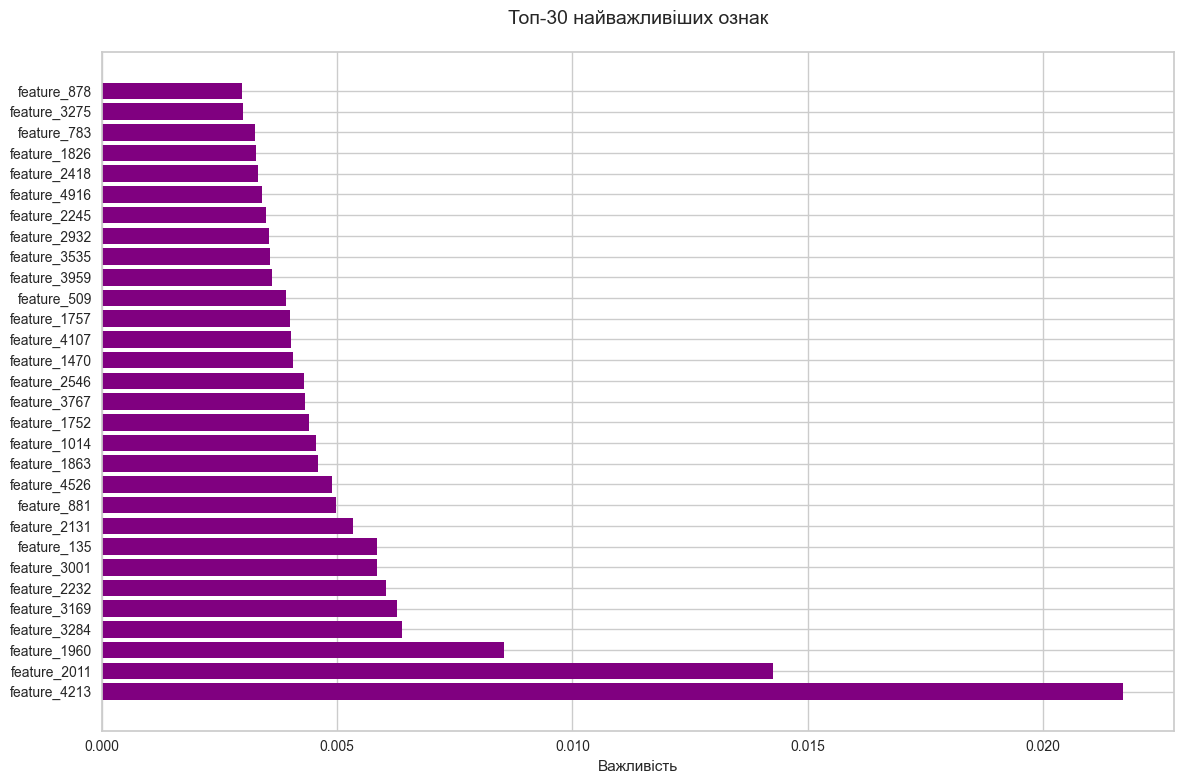

Топ-10 найважливіших слів/фраз:
   - space: 0.0217
   - graphics: 0.0143
   - god: 0.0086
   - people: 0.0064
   - orbit: 0.0063
   - image: 0.0060
   - nasa: 0.0058
   - 3d: 0.0058
   - hi: 0.0053
   - christians: 0.0050


In [42]:
try:
    if hasattr(final_model, 'feature_importances_'):
        importances = final_model.feature_importances_
        indices = np.argsort(importances)[-30:][::-1]
        
        plt.figure(figsize=(12, 8))
        plt.barh(range(30), importances[indices], color='purple')
        plt.yticks(range(30), [f'feature_{indices[i]}' for i in range(30)])
        plt.xlabel('Важливість')
        plt.title('Топ-30 найважливіших ознак', fontsize=14, pad=20)
        plt.tight_layout()
        plt.savefig('feature_importance_detailed.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Мап на реальні слова
        top_features_idx = indices[:10]
        print("Топ-10 найважливіших слів/фраз:")
        for idx in top_features_idx:
            if idx < len(feature_names):
                print(f"   - {feature_names[idx]}: {importances[idx]:.4f}")
    else:
        print("Модель не підтримує feature_importances_")
except Exception as e:
    print(f"Помилка при отриманні важливості ознак: {e}")

In [43]:
MAX_WORDS = 10000
MAX_LEN = 200
EMBEDDING_DIM = 128
BATCH_SIZE = 32
EPOCHS = 10

In [44]:
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['text'])

In [45]:
X_train_seq = tokenizer.texts_to_sequences(df_train['text'])
X_test_seq = tokenizer.texts_to_sequences(df_test['text'])

In [46]:
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

In [69]:
print(f"Dictionary: {len(tokenizer.word_index)}")
print(f"Ttain: {X_train_pad.shape}")
print(f"Test: {X_test_pad.shape}")

Dictionary: 27472
Ttain: (2034, 200)
Test: (1353, 200)


In [48]:
# Конвертація міток у one-hot encoding
num_classes = len(np.unique(y_train))
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [49]:
model = models.Sequential([
    # Embedding шар - перетворює слова у вектори
    layers.Embedding(
        input_dim=MAX_WORDS,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_LEN,
        name='embedding'
    ),
    
    # Bidirectional LSTM - обробляє послідовність в обох напрямках
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), name='bilstm_1'),
    layers.Dropout(0.3, name='dropout_1'),
    
    # Ще один LSTM шар
    layers.Bidirectional(layers.LSTM(32), name='bilstm_2'),
    layers.Dropout(0.3, name='dropout_2'),
    
    # Dense шари для класифікації
    layers.Dense(64, activation='relu', name='dense_1'),
    layers.Dropout(0.3, name='dropout_3'),
    
    layers.Dense(32, activation='relu', name='dense_2'),
    
    # Вихідний шар
    layers.Dense(num_classes, activation='softmax', name='output')
])

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1280000   
                                                                 
 bilstm_1 (Bidirectional)    (None, 200, 128)          98816     
                                                                 
 dropout_1 (Dropout)         (None, 200, 128)          0         
                                                                 
 bilstm_2 (Bidirectional)    (None, 64)                41216     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0

In [51]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [52]:
# Callback для ранньої зупинки
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [53]:
history = model.fit(
    X_train_pad,
    y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10


51/51 [==============================] - 36s 430ms/step - loss: 1.3694 - accuracy: 0.3104 - val_loss: 1.3687 - val_accuracy: 0.3194
Epoch 2/10
51/51 [==============================] - 22s 422ms/step - loss: 1.1913 - accuracy: 0.4481 - val_loss: 1.3575 - val_accuracy: 0.5086
Epoch 3/10
51/51 [==============================] - 20s 383ms/step - loss: 0.9467 - accuracy: 0.5753 - val_loss: 0.9030 - val_accuracy: 0.6020
Epoch 4/10
51/51 [==============================] - 20s 385ms/step - loss: 0.5742 - accuracy: 0.7572 - val_loss: 0.9499 - val_accuracy: 0.6462
Epoch 5/10
51/51 [==============================] - 20s 384ms/step - loss: 0.3475 - accuracy: 0.8636 - val_loss: 1.0747 - val_accuracy: 0.6830
Epoch 6/10
51/51 [==============================] - 19s 382ms/step - loss: 0.2276 - accuracy: 0.9250 - val_loss: 1.0501 - val_accuracy: 0.6634


In [54]:
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.5351
Test Loss: 1.0146


In [55]:
y_pred_nn = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred_nn, axis=1)

43/43 [==============================] - 7s 103ms/step


In [56]:
report_nn = classification_report(
    y_test,
    y_pred_classes,
    target_names=newsgroups_train.target_names
)
print(report_nn)

                    precision    recall  f1-score   support

       alt.atheism       0.45      0.42      0.44       319
     comp.graphics       0.50      0.73      0.59       389
         sci.space       0.72      0.65      0.69       394
talk.religion.misc       0.38      0.19      0.25       251

          accuracy                           0.54      1353
         macro avg       0.51      0.50      0.49      1353
      weighted avg       0.53      0.54      0.52      1353



In [57]:
cm_nn = confusion_matrix(y_test, y_pred_classes)
print(cm_nn)

[[135  98  16  70]
 [ 30 283  72   4]
 [ 11 121 258   4]
 [125  67  11  48]]


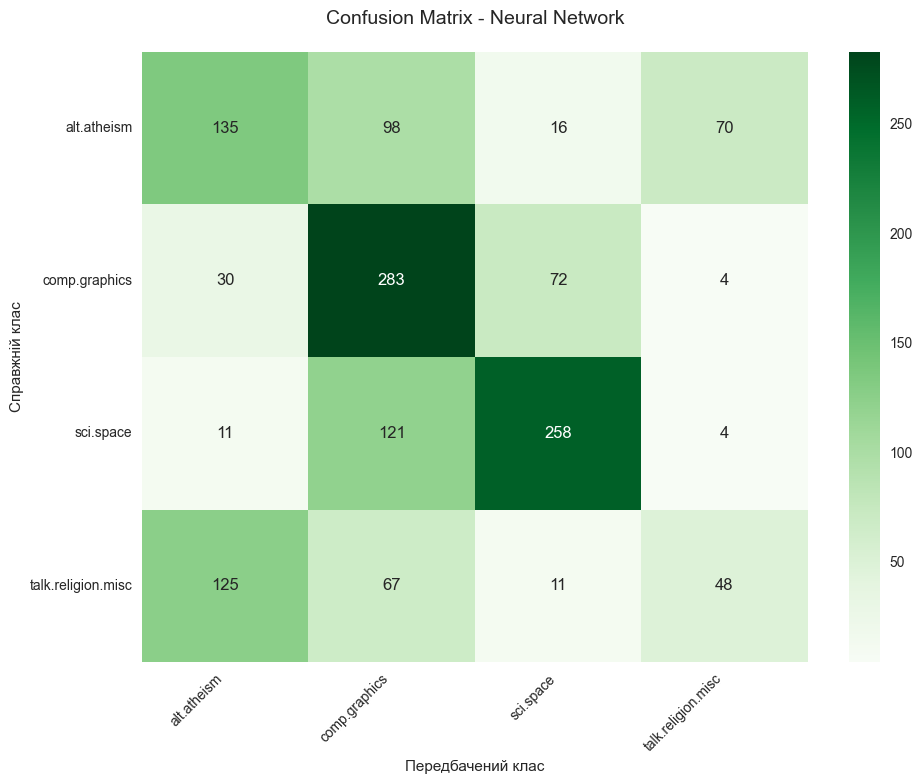

In [58]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_nn,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=newsgroups_train.target_names,
    yticklabels=newsgroups_train.target_names
)
plt.title('Confusion Matrix - Neural Network', fontsize=14, pad=20)
plt.ylabel('Справжній клас')
plt.xlabel('Передбачений клас')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_nn.png', dpi=300, bbox_inches='tight')
plt.show()

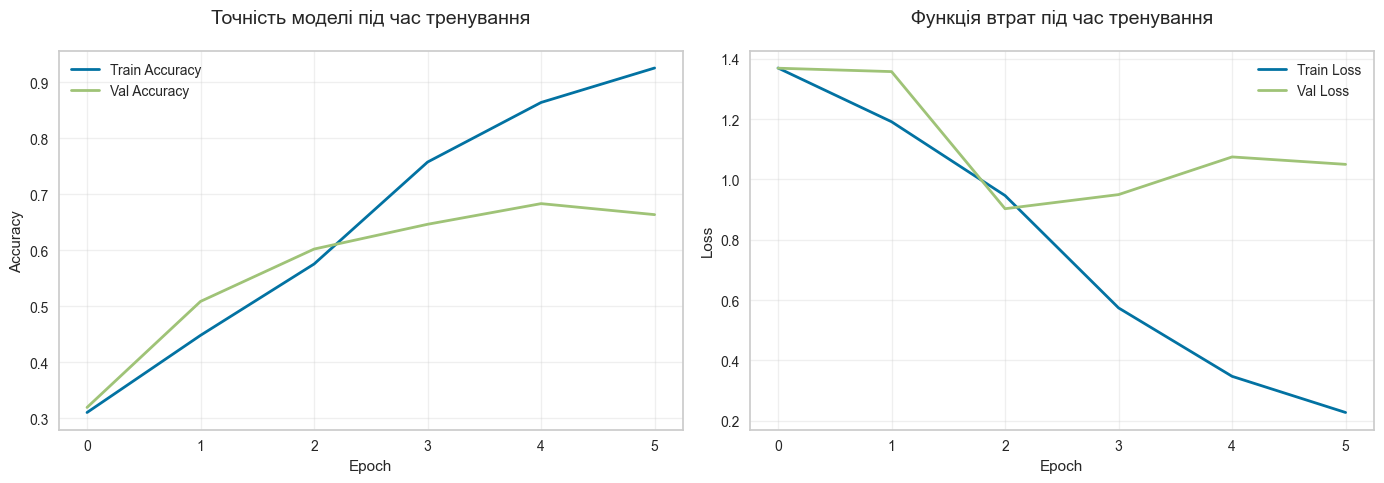

In [59]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('Точність моделі під час тренування', fontsize=14, pad=20)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Функція втрат під час тренування', fontsize=14, pad=20)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [60]:
comparison_data = {
    'Модель': ['PyCaret (Best)', 'Neural Network'],
    'Accuracy': [accuracy, test_accuracy],
    'Type': ['Traditional ML', 'Deep Learning']
}

In [61]:
df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

        Модель  Accuracy           Type
PyCaret (Best)  0.725795 Traditional ML
Neural Network  0.535107  Deep Learning


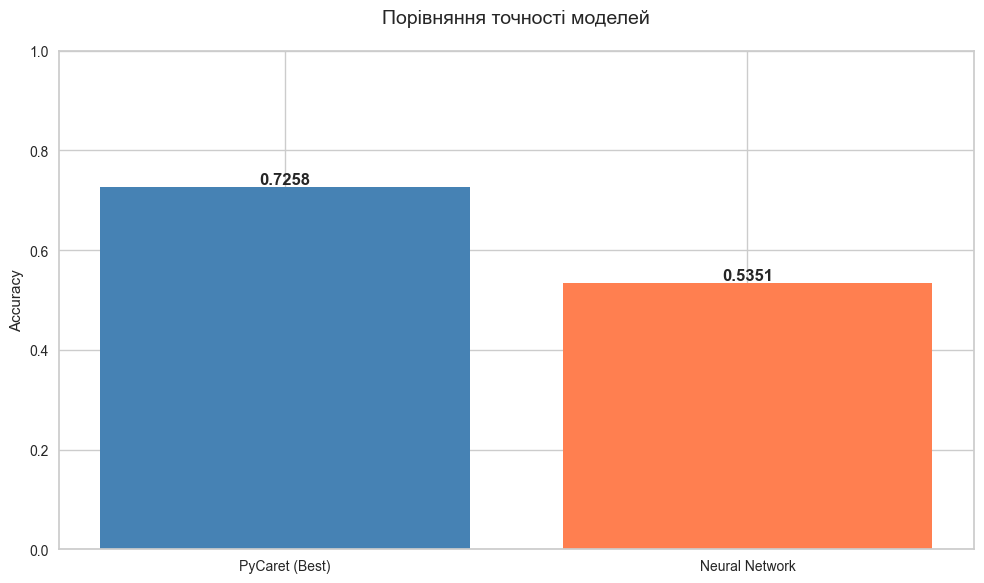

In [62]:
plt.figure(figsize=(10, 6))
bars = plt.bar(df_comparison['Модель'], df_comparison['Accuracy'], 
               color=['steelblue', 'coral'])
plt.title('Порівняння точності моделей', fontsize=14, pad=20)
plt.ylabel('Accuracy')
plt.ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()